# **Introduction to Sionna RT**
Sionna RT is a open-source hardware-accelerated differentiable ray tracer for radio propagation modeling which is built on top of Mitsuba 3. 
In this notebook I have experimented with different functions of Sionna

In [1]:
import sionna.rt

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True #Toggle to use the preview widget

#Relevent components from Sionna
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
    PathSolver, RadioMapSolver, subcarrier_frequencies


## **Scenes**

### **Loading and Visualizing**

In [2]:
#Load integrated scene
scene = load_scene(sionna.rt.scene.munich)

In [3]:
if not no_preview:
    scene.preview()

In [4]:
if not no_preview:
    scene.render(camera="preview",
                 num_samples=512)

In [5]:
if not no_preview:
    scene.render_to_file(camera="preview",
                         filename="scene.png",
                         resolution=[650, 500]);

Number of Samples means, number of rays thrown per pixel

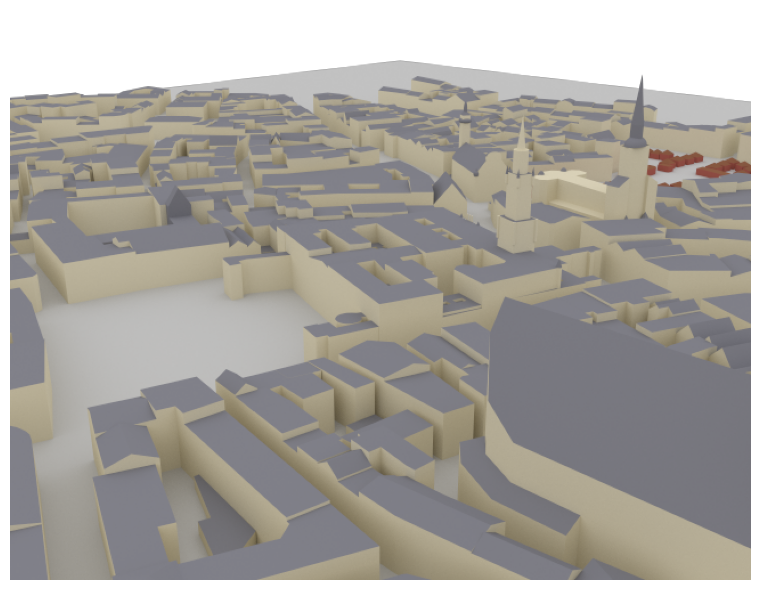

In [6]:
#Create a new Camera with a different configuration
my_cam = Camera(position=[-250, 250, 150], look_at=[-25,30,28])

#Render the scene with new camera*
scene.render(camera=my_cam, resolution=[650,500], num_samples=4096); #increase number of samples to increase quality
scene.render_to_file(camera=my_cam, filename="scene2.jpg", resolution=[2048, 1024]);


### **Inspecting SceneObjects and Editing of Scenes**

In [7]:
scene = sionna.rt.load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes=False)
# scene.preview()
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x784f37e7e920>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x784f37e7d9c0>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x784f37e7da50>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x784f37e7f940>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x784f37e7fcd0>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x784f37e7f370>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x784f37e7cbe0>}

In [8]:
floor = scene.get("floor")

In [9]:
print("Position (x,y,z) [m]:", floor.position)
print("Orientation (alpha, beta, gamma) [rad]:", floor.orientation)
print("Scaling:" , floor.scaling)


Position (x,y,z) [m]: [[-0.769669, 0.238537, -0.0307941]]
Orientation (alpha, beta, gamma) [rad]: [[0, 0, 0]]
Scaling: [[1, 1, 1]]


### **Velocity Vector**
This property is used during the ray tracing process to compute a Doppler shift for every propagation path. This information can then be used to synthetically compute time evolution of channel impulse responses.

In [10]:
print("Velocity (x,y,z) [m/s]: ", floor.velocity)

Velocity (x,y,z) [m/s]:  [[0, 0, 0]]


The radio material determines how an object interacts with incident radio waves.

In [11]:
floor.radio_material

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.123
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

Depending on the type of radio material, some of its properties might change as a function of the frequency of the incident radio wave:

In [12]:
scene.frequency = 28e9 # in Hz; implicitly updates RadioMaterials that implement frequency dependent properties
floor.radio_material # Note that the conductivity (sigma) changes automatically

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.626
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

## **Ray tracing of Propagation Paths**

In [13]:
scene = sionna.rt.load_scene(sionna.rt.scene.munich, merge_shapes=True) #Merge shapes to speed up the computation

#Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

#Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

#Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 display_radius=2)

#Add transmitter instance to the scene
scene.add(tx)

#Create receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              display_radius=2)

#Add receiver instance to the scene
scene.add(rx)

tx.look_at(rx) #Transmitter points towards Receiver

In [24]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver = PathSolver()

#Compute Propagation Paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

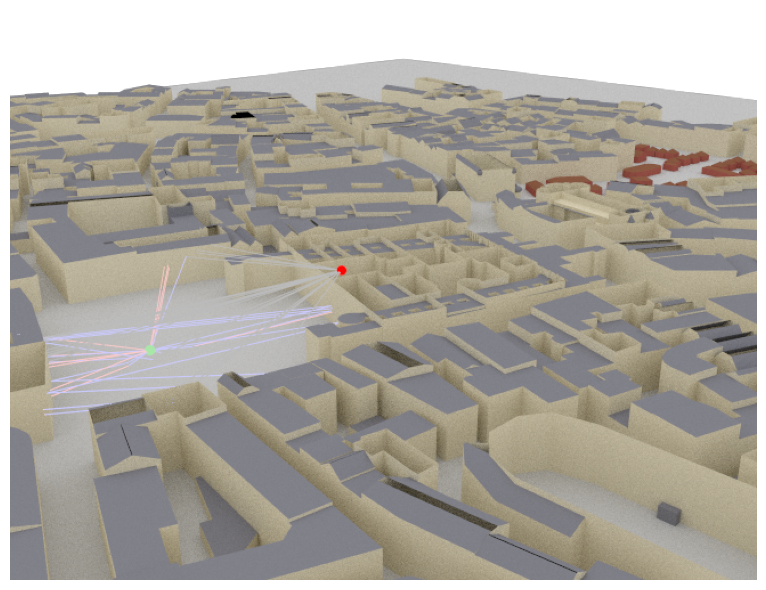

In [26]:
no_preview = True #Toggle to use the preview widget

if no_preview:
    scene.render(camera=my_cam,paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

scene.render_to_file(camera=my_cam, filename="rays.jpg", resolution=[2048, 1024]);

## **From Paths to Channel Impulse and Frequency Responses**

In [16]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

Shape of a:  (1, 2, 1, 1, 21, 1)
Shape of tau:  (1, 2, 1, 1, 21)


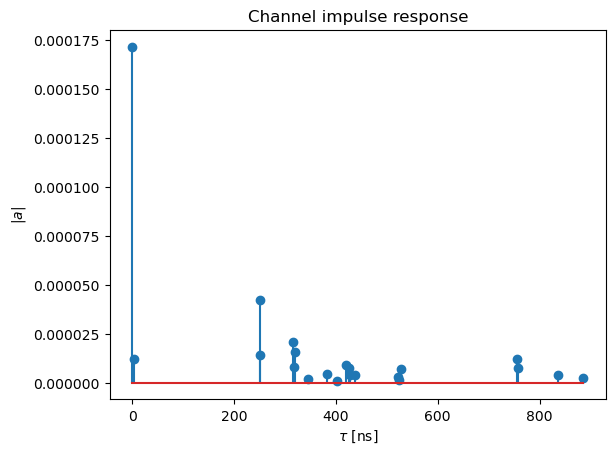

In [27]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");
plt.savefig("CIR.jpg") 

Shape of h_freq:  (1, 2, 1, 1, 1, 1024)


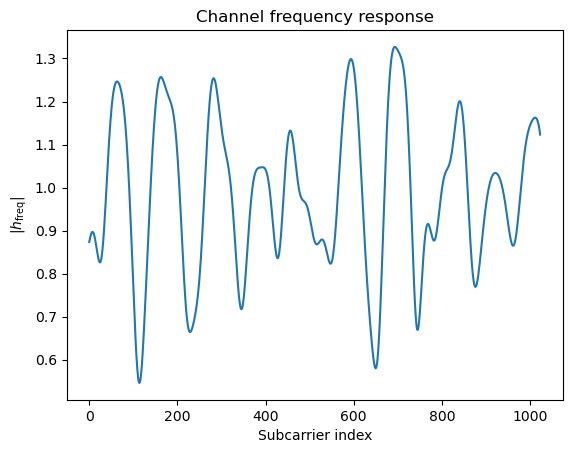

In [28]:
# OFDM System Parameters
num_subcarriers = 1024
subcarrier_spacing = 30e3

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency responses
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True,
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");
plt.savefig("CFR.jpg") 


Shape of taps:  (1, 2, 1, 1, 1, 107)


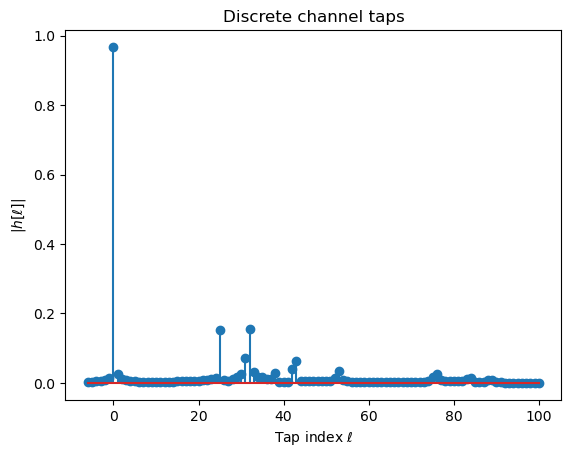

In [29]:
taps = paths.taps(bandwidth=100e6, #Bandwidth to which the channel is low pass filtered
                  l_min=-6, #Smallest time lag
                  l_max=100, #Largest time lag
                  sampling_frequency=None, #Sampling at Nyquist Frequency 1/B
                  normalize=True,
                  normalize_delays=True,
                  out_type="numpy"
                )

print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 101), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");
plt.savefig("taps.jpg") 


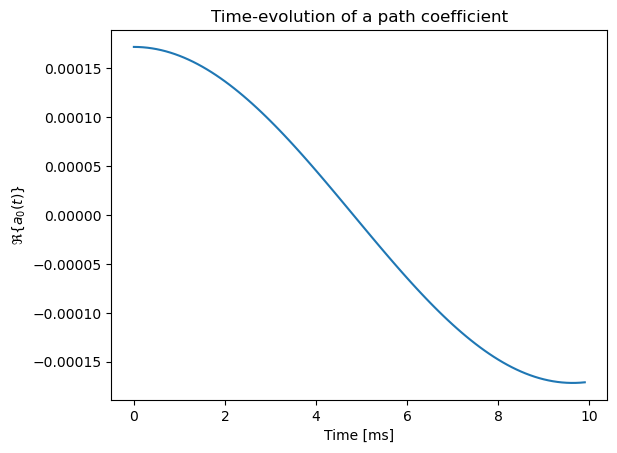

In [34]:
scene.get("tx").velocity = [10, 0, 0]

#Recompute the propagation paths
paths_mob = p_solver(scene=scene,
                     max_depth=5,
                     los=True,
                     specular_reflection=True,
                     diffuse_reflection=False,
                     refraction=True,
                     synthetic_array=True,
                     seed=41)

#Compute CIR with time evolution
num_time_steps = 100
sampling_frequency = 1e4
a_mob, _ = paths_mob.cir(sampling_frequency=sampling_frequency,
                         num_time_steps=num_time_steps,
                         out_type="numpy")

# Inspect time-evolution of a single path coefficient
plt.figure()
plt.plot(np.arange(num_time_steps)/sampling_frequency*1000,
         a_mob[0,0,0,0,0].real);
plt.xlabel("Time [ms]");
plt.ylabel(r"$\Re\{a_0(t) \}$");
plt.title("Time-evolution of a path coefficient");
plt.savefig("time_evolution.jpg")
                     

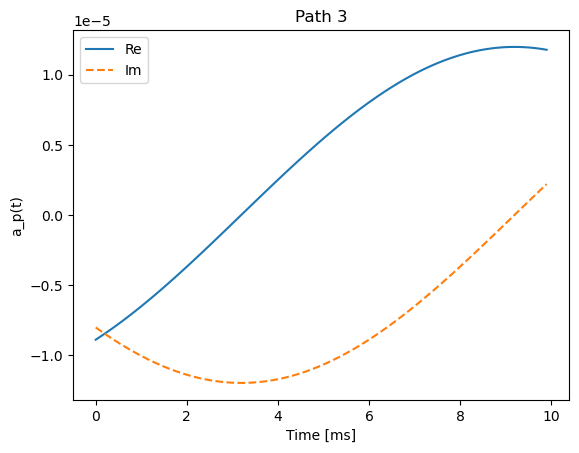

In [21]:
rx, rx_ant, tx, tx_ant = 0, 0, 0, 0
t = np.arange(num_time_steps)/sampling_frequency*1e3  # ms
num_paths = a_mob.shape[4]

p = 3  # <-- pick a path index (0 .. num_paths-1)
plt.figure()
plt.plot(t, a_mob[rx, rx_ant, tx, tx_ant, p, :].real, label="Re")
plt.plot(t, a_mob[rx, rx_ant, tx, tx_ant, p, :].imag, "--", label="Im")
plt.xlabel("Time [ms]"); plt.ylabel("a_p(t)"); plt.title(f"Path {p}")
plt.legend(); plt.show()


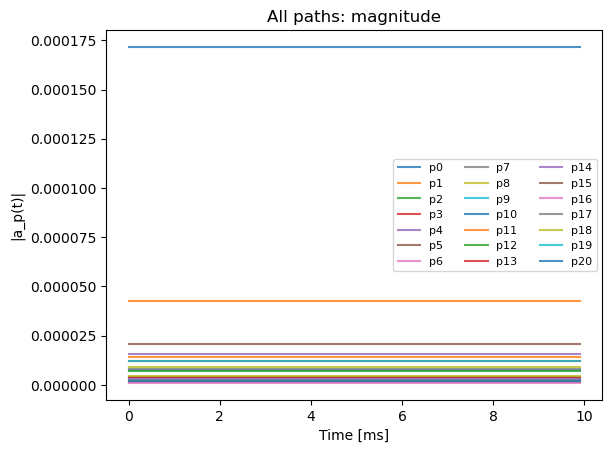

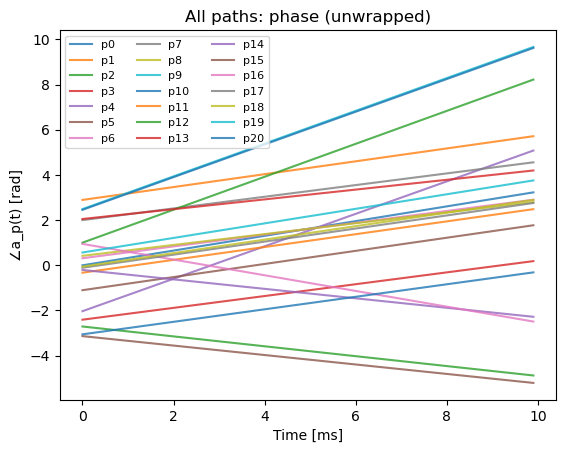

In [ ]:
A = a_mob[rx, rx_ant, tx, tx_ant]  # shape: [num_paths, num_time_steps]

# Magnitude vs time
plt.figure()
for p in range(A.shape[0]):
    plt.plot(t, np.abs(A[p]), alpha=0.8, label=f"p{p}")
plt.xlabel("Time [ms]"); plt.ylabel("|a_p(t)|"); plt.title("All paths: magnitude")
plt.legend(ncol=3, fontsize=8); plt.show()

# Unwrapped phase vs time (Doppler slopes)
plt.figure()
for p in range(A.shape[0]):
    plt.plot(t, np.unwrap(np.angle(A[p])), alpha=0.8, label=f"p{p}")
plt.xlabel("Time [ms]"); plt.ylabel("∠a_p(t) [rad]"); plt.title("All paths: phase (unwrapped)")
plt.legend(ncol=3, fontsize=8); plt.show()


## **Radio Maps**

In [31]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[1,1],
               samples_per_tx=10**6
                )

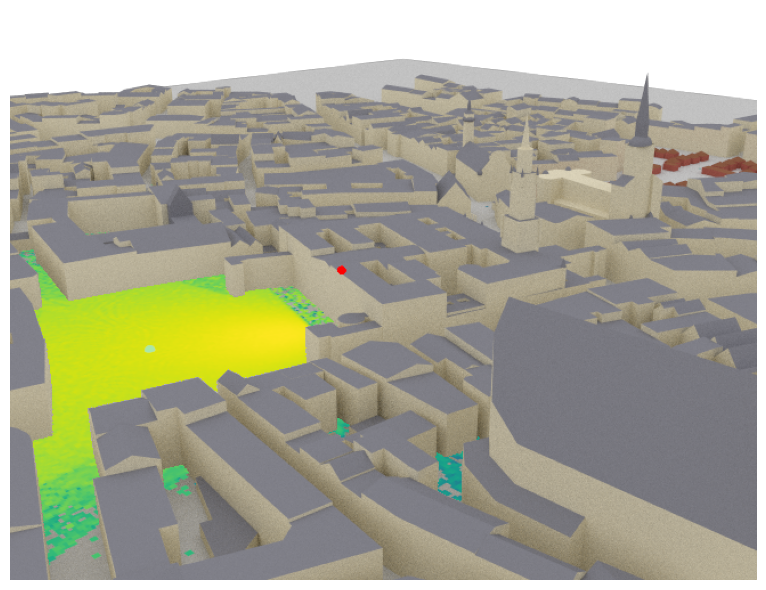

In [33]:
if no_preview:
    scene.render(camera=my_cam, radio_map=rm);
else:
    scene.preview(radio_map=rm);
    
scene.render_to_file(camera=my_cam, radio_map=rm, filename="radio_map.jpg", resolution=[2048, 1024]);